In [1]:
# Crypto plot

In [2]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import scipy
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use('seaborn')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [3]:
url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=10&e=Coinbase"
f = requests.get(url)
ipdata = f.json()
pd.DataFrame(ipdata['Data']).head(5)

,time,close,high,low,open,volumefrom,volumeto
0,1580256000,9288.44,9439.83,9224.75,9394.50,12035.69,1.123477e+08
1,1580342400,9503.08,9574.68,9185.00,9288.44,11818.13,1.109687e+08
2,1580428800,9334.98,9522.50,9195.49,9503.08,9435.38,8.801173e+07
3,1580515200,9380.18,9458.08,9285.01,9334.98,4383.54,4.108205e+07
4,1580601600,9323.50,9480.00,9140.00,9380.18,6839.38,6.399854e+07


In [4]:
def get_data(date):
    """query API for 2000 days historical price data starting from "date"."""
    url = "https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000&toTs={}".format(
        date)
    r = requests.get(url)
    ipdata = r.json()
    return ipdata

In [5]:
def get_df(from_date, to_date):
    date = to_date
    holder = []
    # while earliest date returned is later than the earliest data requested, keep querying API # and adding results to list
    while date > from_date:
        data = get_data(date)
        holder.append(pd.DataFrame(data['Data']))
        date = data['TimeFrom']
        # join together all api queries from list
        df = pd.concat(holder, axis=0)
        # remove data points from before from_date
        df = df[df['time'] > from_date]
        # convert to timestamp
        df['time'] = pd.to_datetime(df['time'], unit='s')
        df.set_index('time', inplace=True)
        return df

In [6]:
# Make dataframe for each month to plot

df_sept = get_df(1567296000, 1569801600)
df_oct = get_df(1569888000, 1572480000)
df_nov = get_df(1572566400, 1575294994)
df_dec = get_df(1575158400, 1577824197)
df_jan = get_df(1577910597, 1581204226)


# Select the close column of dataframes
df_sept_a = df_sept[['close']]
df_oct_a = df_oct[['close']]
df_nov_a = df_nov[['close']]
df_dec_a = df_dec[['close']]
df_jan_a = df_jan[['close']]


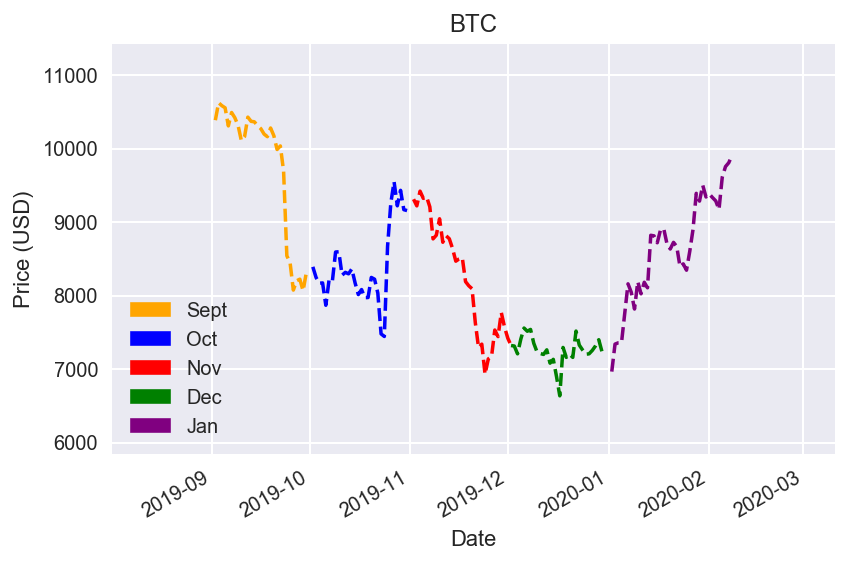

In [7]:
# Plot dataframes on same plot
plt.plot(df_sept_a, linestyle='dashed', label='September', color='orange')
plt.plot(df_oct_a, linestyle='dashed', label='October', color='blue')
plt.plot(df_nov_a, linestyle='dashed', label='November', color='red')
plt.plot(df_dec_a, linestyle='dashed', label='December', color='green')
plt.plot(df_jan_a, linestyle='dashed', label='January', color='purple')

# Assign the colors to corresponding months/ a legend
orange_patch = mpatches.Patch(color='orange', label='Sept')
blue_patch = mpatches.Patch(color='blue', label='Oct')
red_patch = mpatches.Patch(color='red', label='Nov')
green_patch = mpatches.Patch(color='green', label='Dec')
purple_patch = mpatches.Patch(color='purple', label='Jan')

plt.legend(handles=[orange_patch, blue_patch, red_patch, green_patch, purple_patch], loc='lower left')
plt.title('BTC')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=30, ha='right')
plt.margins(0.2)
plt.tight_layout()
plt.show()
plt.close()

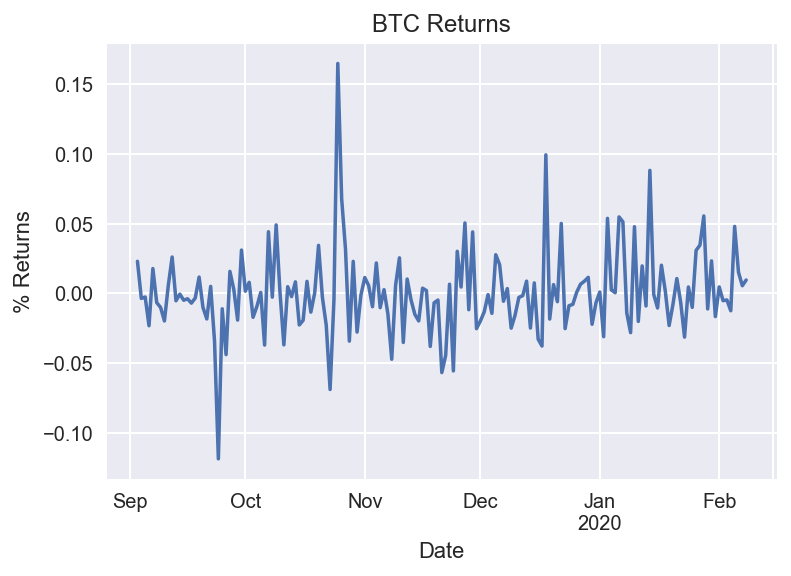

In [8]:
# September 1st - Today
df_all = get_df(1567296000, 1581204226)

# Add a returns column
df_all['Returns'] = df_all['close'].pct_change()

df_all['Returns'].plot()
plt.axis('tight')
plt.title('BTC Returns')
plt.xlabel('Date')
plt.ylabel('% Returns')
plt.show();

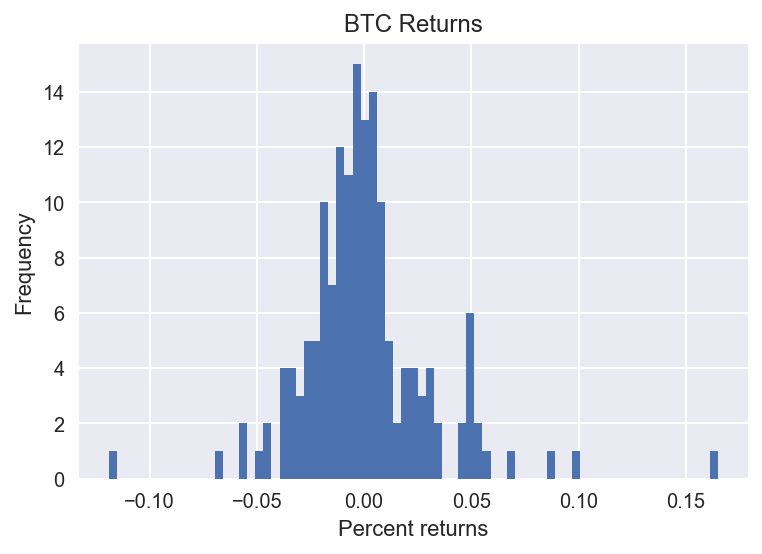

In [9]:
# Plot returns
plt.hist(df_all['Returns'].dropna(), bins=75, density=False)
plt.title('BTC Returns')
plt.xlabel('Percent returns')
plt.ylabel('Frequency')
plt.show();

In [10]:
from scipy.stats import skew

clean_returns = (df_all['Returns'].dropna())

returns_skewness = skew(clean_returns)
print(returns_skewness)

1.049722726599182


In [11]:
from scipy.stats import kurtosis

excess_kurtosis = kurtosis(clean_returns)
print(excess_kurtosis)

fourth_moment = excess_kurtosis + 3
print(fourth_moment)

6.179671311810889
9.179671311810889


## Testing for normality

In [12]:
from scipy.stats import shapiro

shapiro_results = shapiro(clean_returns)
print('Shapiro results:', shapiro_results)

p_value = shapiro_results[1]
print('P-value: ', p_value)

Shapiro results: (0.9029355049133301, 9.199325745612441e-09)
P-value:  9.199325745612441e-09


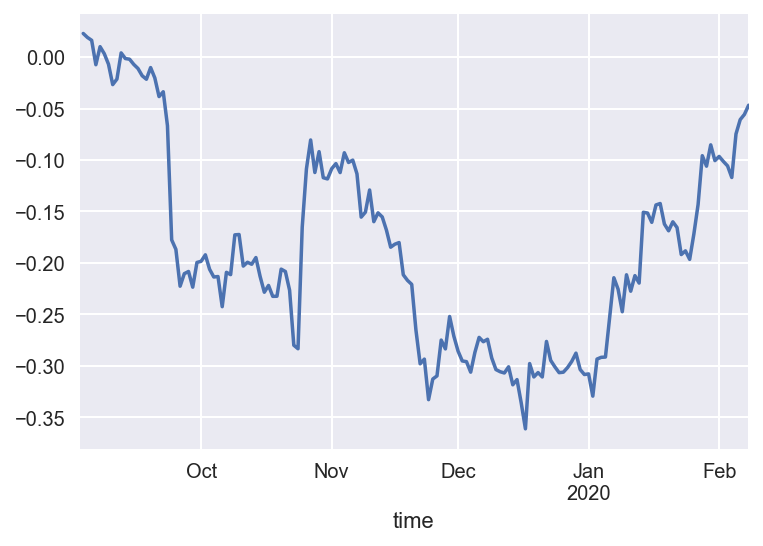

In [13]:
CumulativeReturns = ((1 + df_all['Returns']).cumprod()-1) 
CumulativeReturns.plot();